# Projet Fraude bancaire propre : Création des modèles

In [12]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import sys 
import fastparquet
from dask_ml.preprocessing import DummyEncoder
import pickle
import dask_ml 
from dask import delayed
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt
from dask_ml.preprocessing import StandardScaler

# Algorithmes
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
os.getcwd()

'/home/elisa/Documents/M2_SISE/BigDataMining/Projet_Fraude'

## I. Importation du dataset
Le pré-traitement du dataset a déjà été fait en amont. Nous importons donc directement le fichier au format dask à partir d'un format parquet.

In [3]:
df = dd.read_parquet('guillaumeb_parquet')
df.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,0,20.00,1,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,0,20.00,1,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,0,57.64,1,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,0,54.29,0,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,0,26.90,1,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


## II. Subdivision en apprentissage/test
 - dfTrain : du 2017-02-01 au 2017-08-31
 - dfTest : du 2017-09-01 au 2017-11-30

In [4]:
# Canger le type de la variable "CodeDecision"
df['CodeDecision'] = df['CodeDecision'].astype('object')

In [5]:
dfTrain = df.loc[df['Date'] <= '2017-08-31']
dfTest = df.loc[df['Date'] >= '2017-09-01']
dfTrain.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,0,20.00,1,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,0,20.00,1,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,0,57.64,1,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,0,54.29,0,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,0,26.90,1,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


## III. Définir la variable cible (y) et les variables explicatives (X)

In [6]:
# Définir la variable cible 
yTrain = dfTrain["FlagImpaye"]
yTest = dfTest["FlagImpaye"]

In [7]:
# Définir les variables explicatives 
XTrain = dfTrain.drop(["FlagImpaye", "Date", "Heure"], axis = "columns")
XTest = dfTest.drop(["FlagImpaye", "Date", "Heure"], axis = "columns")

## IV. Recodage de la variable "CodeDecision" dans les varaibles explicatives
- Rmq : La variable qualitative "CodeDecision" possède les modalités 0, 1, 2 et 3 dans dfTrain et les modalités 0, 2 et 3 dans dfTest. 
- Notre stratégie est la suivante : 
    1. Recodage de la variable "CodeDecision" dans les variables explicatives XTrain et XTest.
    2. Comme la variable "CodeDecision_1" n'est présente que dans XTrain, elle devient inutile. Nous décidons donc de la supprimer.

In [8]:
# Exposition du problème 
print("Dans le dataframe d'apprentissage :")
print(dfTrain['CodeDecision'].value_counts().compute())
print("-------------------------------------------------------")
print("Dans le dataframe de test :")
print(dfTest['CodeDecision'].value_counts().compute())

Dans le dataframe d'apprentissage :
0    2760391
1    1121626
2      15138
3       2207
Name: CodeDecision, dtype: int64
-------------------------------------------------------
Dans le dataframe de test :
0    742395
2      4424
3       591
Name: CodeDecision, dtype: int64


In [9]:
# 1) Recodage de la variable "CodeDecision" dans les variables explicatives 
XTrain_ok = dd.get_dummies(XTrain.categorize(), prefix=['CodeDecision'])
XTest_ok = dd.get_dummies(XTest.categorize(), prefix=['CodeDecision'])

# 2) Supprimer la variable "CodeDecision_1" de dfTrain
XTrain_ok = XTrain_ok.drop(["CodeDecision_1"], axis = "columns")
XTrain_ok.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,0,0,0
1,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,0,0,0
2,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,0,0,0
3,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,1,0,0
4,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,0,0,0


## IV. Centrer-réduire les données

In [14]:
# Instanciation de StandardScaler pour centrer réduire les données
scaler = StandardScaler()

XTrain_ok_scale = scaler.fit_transform(XTrain_ok)
XTest_ok_scale = scaler.fit_transform(XTest_ok)
XTrain_ok_scale.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,-0.420302,1.017656,-0.084590,-0.239505,-0.275801,-0.030212,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.455513,-0.202861,-1.556786,-0.062428,-0.023797
1,-0.420302,1.017656,-0.084590,-0.239505,-0.275801,0.162138,0.818043,-0.043812,4.975724,-1.945875,-0.301229,-0.451325,-0.371994,0.038808,-1.556786,-0.062428,-0.023797
2,-0.022127,1.008573,-0.084590,-0.239505,-0.275801,0.562636,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.090397,-0.202861,-1.556786,-0.062428,-0.023797
3,-0.057565,-0.272152,-0.084590,-0.239505,-0.275801,1.172099,0.906727,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.122893,-0.202861,0.642349,-0.062428,-0.023797
4,-0.347310,1.008573,-0.084434,0.637044,-0.273204,0.104780,0.818043,-0.043812,-0.194165,-1.757421,-0.301229,-0.451325,-0.075750,0.702346,-1.556786,-0.062428,-0.023797


## V. Algorithmes

In [10]:
def Calcul_CA(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable CA
    dfmerge["CA"] = dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "CA"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "CA"] = 0.8 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "CA"] = 1 - np.exp(1/dfmerge["Montant"])
    
    # Calcul du CA_total
    CA_total = dfmerge["CA"].sum()
    
    return CA_total

In [19]:
"""Création de la fonction de déploiement d'un modèle sur les données de test"""

def deploiement(modele, XTest, yTest, scale):
    XTest_ = XTest
    
    scaler = StandardScaler()
    
    if scale == True:
        XTest = scaler.fit_transform(XTest)
    
    print("-------------------------------------------------------")
    # Importation du modèle 
    fichier = open(modele, "rb")
    mdl = pickle.load(fichier)
    fichier.close()
    
    # Affichage du modèle 
    print('Modèle :\n', mdl)
    print("-------------------------------------------------------")
    # Prédiction
    Ypred = delayed(mdl.predict)(XTest).compute()
    # Prédiction des scores
    Yscore = delayed(mdl.predict_proba)(XTest).compute()
    
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(yTest, Ypred)
    cr = delayed(classification_report)(yTest, Ypred)
    auc = delayed(roc_auc_score)(yTest, Ypred)

    print('Estimateurs :\n', cr.compute())
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm.compute())
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc.compute())
    print("-------------------------------------------------------")
    
    # BONUS :  Calcul du chiffre d'affaire
    CA_total = Calcul_CA(Montant = XTest_["Montant"].compute(), yReel = yTest.compute(), yPred = Ypred)
    print("Chiffre d'affaire = " + str(round(CA_total, 2)) + " euros")
    print("-------------------------------------------------------")

    # Courbe ROC
    skplt.metrics.plot_roc(yTest, Yscore, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(yTest, Yscore, classes_to_plot = 1, plot_micro = False)
    return CA_total

### -------- Algorithme n°1 : Arbre de décision --------

### a. Création, entrainement et exportation du modele

In [12]:
# Instanciation 
dtree = DecisionTreeClassifier(random_state = 0)

# Structure de l'entrainement
delayed_fit = delayed(dtree.fit)(XTrain_ok, yTrain)

In [13]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

DecisionTreeClassifier(random_state=0)


In [14]:
# Exportation du modèle 
f = open("modele1.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle 

-------------------------------------------------------
Modèle :
 DecisionTreeClassifier(random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.63      0.68      0.65      6573

    accuracy                           0.99    747410
   macro avg       0.81      0.84      0.83    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[738224   2613]
 [  2103   4470]]
-------------------------------------------------------
Auc Score :
 0.8382638389285995
-------------------------------------------------------
Chiffre d'affaire = 45829870.8 euros
-------------------------------------------------------


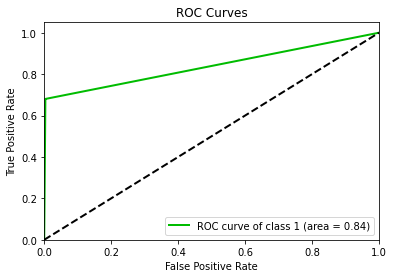

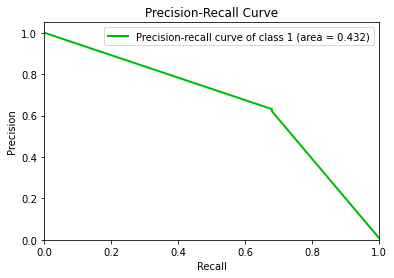

In [40]:
dep1 = deploiement(modele = "modele1.sav", XTest = XTest_ok, yTest = yTest, scale = False)

### -------- Algorithme n°2 : RandomForest --------

### a. Création, entrainement et exportation du modele

In [16]:
# Instanciation 
RandomForest = RandomForestClassifier(n_estimators = 10, random_state = 0)

# Structure de l'entrainement
delayed_fit = delayed(RandomForest.fit)(XTrain_ok, yTrain)

In [17]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

RandomForestClassifier(n_estimators=10, random_state=0)


In [18]:
# Exportation du modèle 
f = open("modele2.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 RandomForestClassifier(n_estimators=10, random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.98      0.67      0.80      6573

    accuracy                           1.00    747410
   macro avg       0.99      0.83      0.90    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740748     89]
 [  2177   4396]]
-------------------------------------------------------
Auc Score :
 0.8343382288653698
-------------------------------------------------------
Chiffre d'affaire = 45884788.83 euros
-------------------------------------------------------


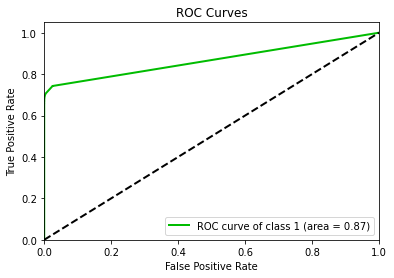

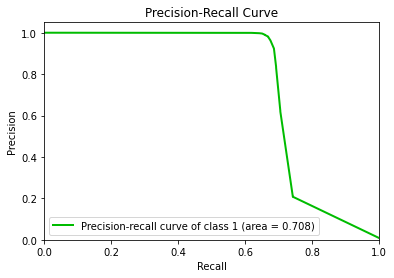

In [22]:
dep2 = deploiement(modele = "modele2.sav", XTest = XTest_ok, yTest = yTest, scale = False)

### -------- Algorithme n°3 : Régression logistique "simple" --------
Régression logistique "simple" sur les données centrées-réduites.

### a. Création, entrainement et exportation du modele

In [15]:
# Instanciation 
clf = LogisticRegression(random_state=0)

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_ok_scale, yTrain)

In [16]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(random_state=0)


In [17]:
# Exportation du modèle 
f = open("modele3.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.88      0.01      0.02      6573

    accuracy                           0.99    747410
   macro avg       0.94      0.51      0.51    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740826     11]
 [  6491     82]]
-------------------------------------------------------
Auc Score :
 0.5062302147902517
-------------------------------------------------------
Chiffre d'affaire = 45871402.78 euros
-------------------------------------------------------


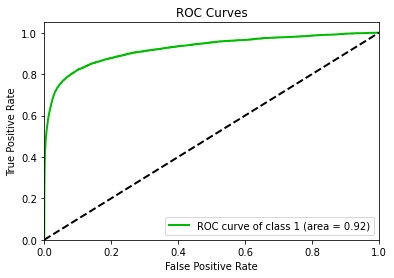

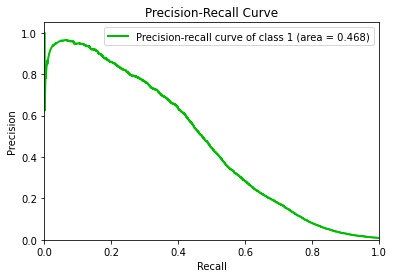

In [20]:
dep3 = deploiement(modele = "modele3.sav", XTest = XTest_ok, yTest = yTest, scale = True)

### -------- Algorithme n°4 : Régression logistique avec le solveur 'saga' --------
Régression logistique avec le solveur 'saga', recommandé pour les grands jeux de données.

### a. Création, entrainement et exportation du modele

In [23]:
# Instanciation 
clf = LogisticRegression(random_state=0, solver='saga')

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_ok_scale, yTrain)

In [24]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(random_state=0, solver='saga')


/home/elisa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [25]:
# Exportation du modèle 
f = open("modele4.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0, solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.96      0.65      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.98      0.82      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740663    174]
 [  2300   4273]]
-------------------------------------------------------
Auc Score :
 0.824924403082035
-------------------------------------------------------
Chiffre d'affaire = 45871685.08 euros
-------------------------------------------------------


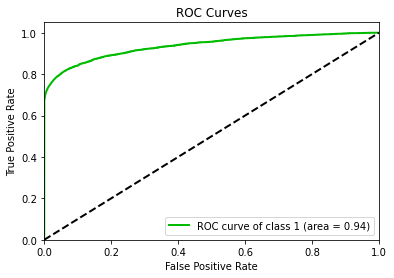

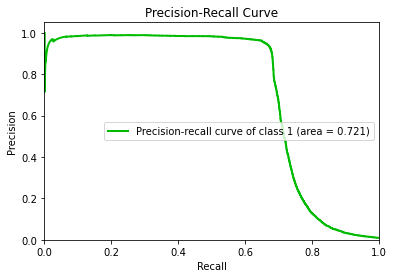

In [26]:
dep4 = deploiement(modele = "modele4.sav", XTest = XTest_ok, yTest = yTest, scale = True)

## -------- Algorithme n°5 : Régression logistique LASSO --------
Régression logistique LASSO avec le paramètre penalty = 'l1' en utilisant le solveur 'saga'.

### a. Création, entrainement et exportation du modele

In [27]:
# Instanciation 
clf = LogisticRegression(random_state=0, penalty='l1', solver='saga', C=0.1)

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_ok_scale, yTrain)

In [28]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(C=0.1, penalty='l1', random_state=0, solver='saga')


/home/elisa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [29]:
# Exportation du modèle 
f = open("modele5.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(C=0.1, penalty='l1', random_state=0, solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.96      0.65      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.98      0.82      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740663    174]
 [  2300   4273]]
-------------------------------------------------------
Auc Score :
 0.824924403082035
-------------------------------------------------------
Chiffre d'affaire = 45871685.08 euros
-------------------------------------------------------


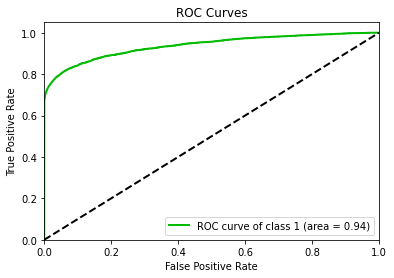

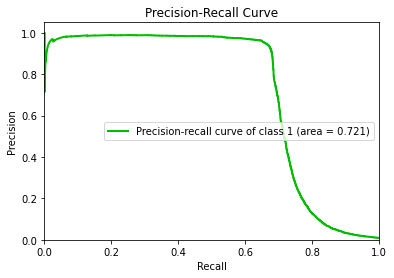

In [30]:
dep5 = deploiement(modele = "modele5.sav", XTest = XTest_ok, yTest = yTest, scale = True)

## -------- Algorithme n°6 : Régression logistique RIDGE --------¶
Régression logistique RIDGE avec le paramètre penalty = 'l2' en utilisant le solveur 'saga'.

### a. Création, entrainement et exportation du modele

In [31]:
# Instanciation 
clf = LogisticRegression(random_state=0, penalty='l2', solver='saga', C=0.1)

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_ok_scale, yTrain)

In [32]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(C=0.1, random_state=0, solver='saga')


/home/elisa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [33]:
# Exportation du modèle 
f = open("modele6.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(C=0.1, random_state=0, solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.96      0.65      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.98      0.82      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740663    174]
 [  2300   4273]]
-------------------------------------------------------
Auc Score :
 0.824924403082035
-------------------------------------------------------
Chiffre d'affaire = 45871685.08 euros
-------------------------------------------------------


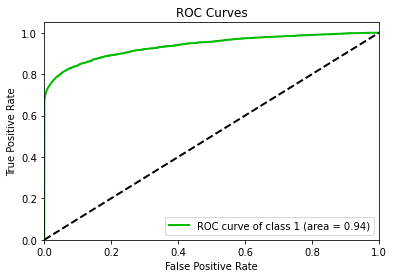

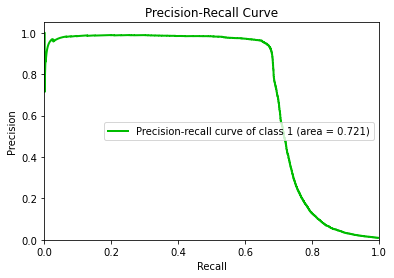

In [34]:
dep6 = deploiement(modele = "modele6.sav", XTest = XTest_ok, yTest = yTest, scale = True)

## -------- Algorithme n°7 : Régression logistique ELASTICNET --------¶
Régression logistique ELASTICNET en basculant le paramètre penalty = 'elasticnet' avec un l1_ratio = 0.5 pour ne favoriser ni RIDGE, ni LASSO.

### a. Création, entrainement et exportation du modele

In [35]:
# Instanciation 
clf = LogisticRegression(random_state=0, penalty='elasticnet', l1_ratio=0.5, solver='saga', C=0.01)

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_ok_scale, yTrain)

In [36]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet', random_state=0,
                   solver='saga')


/home/elisa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [37]:
# Exportation du modèle 
f = open("modele7.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet', random_state=0,
                   solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.96      0.65      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.98      0.82      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740663    174]
 [  2300   4273]]
-------------------------------------------------------
Auc Score :
 0.824924403082035
-------------------------------------------------------
Chiffre d'affaire = 45871685.08 euros
-------------------------------------------------------


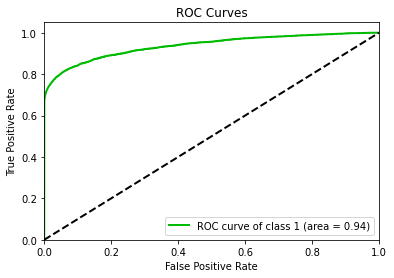

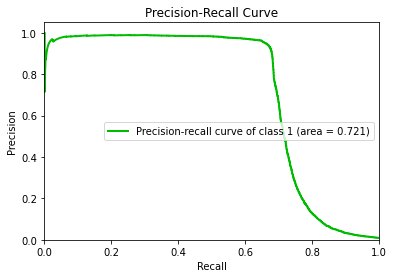

In [38]:
dep7 = deploiement(modele = "modele7.sav", XTest = XTest_ok, yTest = yTest, scale = True)

## V. Comparaison des modèles

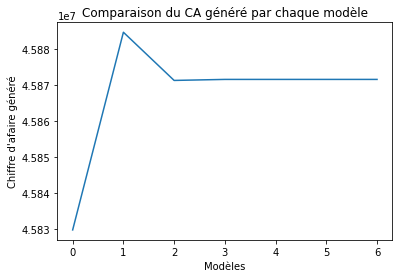

In [41]:
# Comparaison du CA généré par chaque modèle
dep = [dep1, dep2, dep3, dep4, dep5, dep6, dep7]
plt.plot(dep)
plt.ylabel("Chiffre d'afaire généré")
plt.xlabel("Modèles")
plt.title("Comparaison du CA généré par chaque modèle") 
plt.show()